<a href="https://colab.research.google.com/github/shmanth/Deep_Convolutional_Generative_Adversial_Network_MNIST-IIITB-Assignment/blob/master/Deep_Convolutional_Generative_Adversial_Network_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### In this notebook, Deep convolutional generative adversial network is used to generate the MNIST Images

In [ ]:
#Importing libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import imageio
from skimage.transform import resize
from IPython import display
from keras.utils import plot_model

##Loading the data

In [ ]:
# Loading the mnist data
(train_images,train_labels),(_,_)= tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


###Visualization




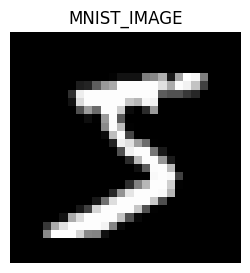

Image_label: 5
Image_shape: (28, 28)


In [ ]:
# visualizing a image from the dataset
plt.figure(figsize=(3,3))
plt.imshow(train_images[0],cmap='gray')
plt.axis('off')
plt.title('MNIST_IMAGE')
plt.show()
print('Image_label:',train_labels[0])
print('Image_shape:',train_images[0].shape)

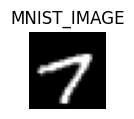

Image_label: 7
Image_shape: (28, 28)


In [ ]:
# visualizing another image from the dataset
plt.figure(figsize=(1,1))
plt.imshow(train_images[101],cmap='gray')
plt.axis('off')
plt.title('MNIST_IMAGE')
plt.show()
print('Image_label:',train_labels[101])
print('Image_shape:',train_images[101].shape)

###Data_Preprocessing

In [ ]:
Buffer_size=60000 # amount of data fed to ram at a time
batch_size=2000 # batch data for gpu in each training step
noise_dim=100 # noise for the generator

In [ ]:
# Normalizing the images to range of -1 to 1
train_data=(train_images/127.5)-1.0

In [ ]:
# resizing images to 32*32(2^5) to make computations of image easy for gpu
train_images= np.zeros((Buffer_size,32,32))
for index, img in enumerate(train_data):
  train_images[index,:,:]= resize(img,(32,32))

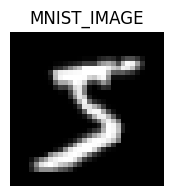

Image_label: 5
Image_shape: (32, 32)


In [ ]:
# visualizing image to see changes in size
plt.figure(figsize=(2,2))
plt.imshow(train_images[0],cmap='gray')
plt.axis('off')
plt.title('MNIST_IMAGE')
plt.show()
print('Image_label:',train_labels[0])
print('Image_shape:',train_images[0].shape)

In [ ]:
# Reshaping the images to add channel dimention
train_images= train_images.reshape(train_images.shape[0],32,32,1).astype('float32')

In [ ]:
# convert numpy to tensor format ,shuffle and store data in batches
train_data= tf.data.Dataset.from_tensor_slices(train_images).shuffle(Buffer_size, seed=42).batch(batch_size)

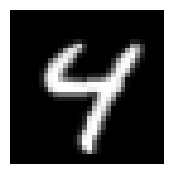

shape: (32, 32, 1)


In [ ]:
#visualizing the image to check changes
sample= next(iter(train_data))
plt.figure(figsize=(2,2))
plt.imshow(sample[0].numpy()[:,:,0],cmap='gray')
plt.axis('off')
plt.show()
print('shape:',sample[0].shape)

## Model Building

In [ ]:
# Genertor
def generator():
  model=tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(4*4*128, use_bias=False, input_shape=(noise_dim,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape((4,4,128)))

  model.add(tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), use_bias= False, padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(64,(3,3), strides=(2,2), use_bias=False, padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(1,(3,3), strides=(2,2), use_bias=False, padding='same',activation='tanh'))

  return model

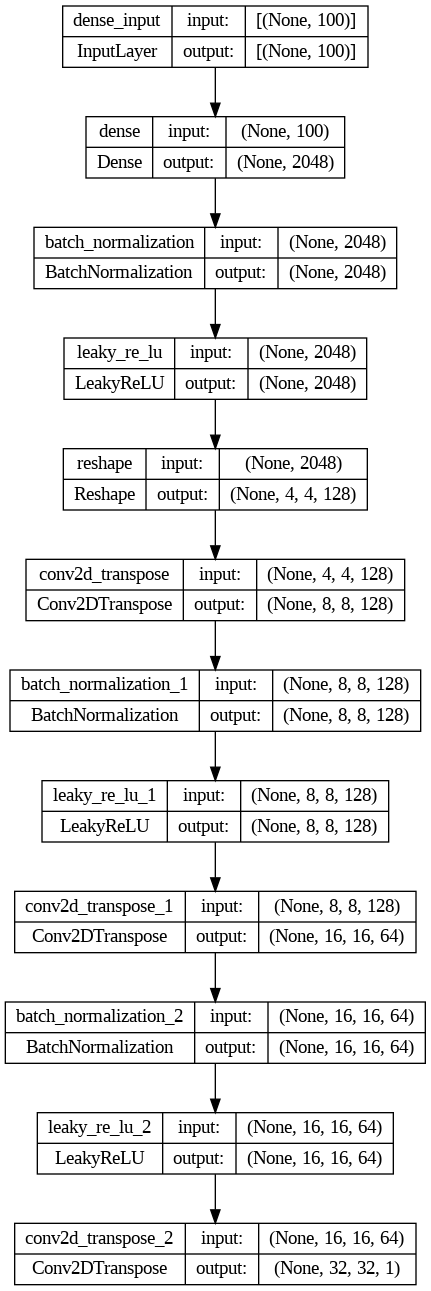

In [ ]:
Generator= generator()
plot_model(Generator, show_shapes=True, show_layer_names= True)

#### Generate a initial image from generator

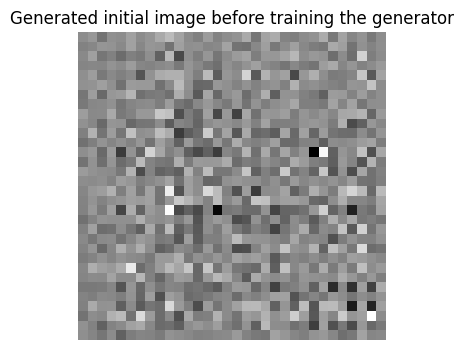

In [ ]:
constant_noise= tf.random.normal([1, noise_dim])
Generated_img= Generator(constant_noise, training= False)

plt.figure(figsize=(4,4))
plt.imshow(Generated_img[0,:,:,0],cmap='gray')
plt.axis('off')
plt.title('Generated initial image before training the generator')
plt.show()

In [ ]:
# Discriminator model building using convolutional layers

def discriminator_model():
  model= tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(16,(3,3), strides=(1,1), use_bias= False, input_shape=[32,32,1]))
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(32,(3,3), strides=(1,1), use_bias= False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(64, (3,3), strides=(1,1), use_bias= False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(128, (3,3), strides=(1,1), use_bias= False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(256, (5,5), strides=(2,2), use_bias= False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2D(1,(10,10), strides=(1,1)))

  model.add(tf.keras.layers.Flatten())

  return model

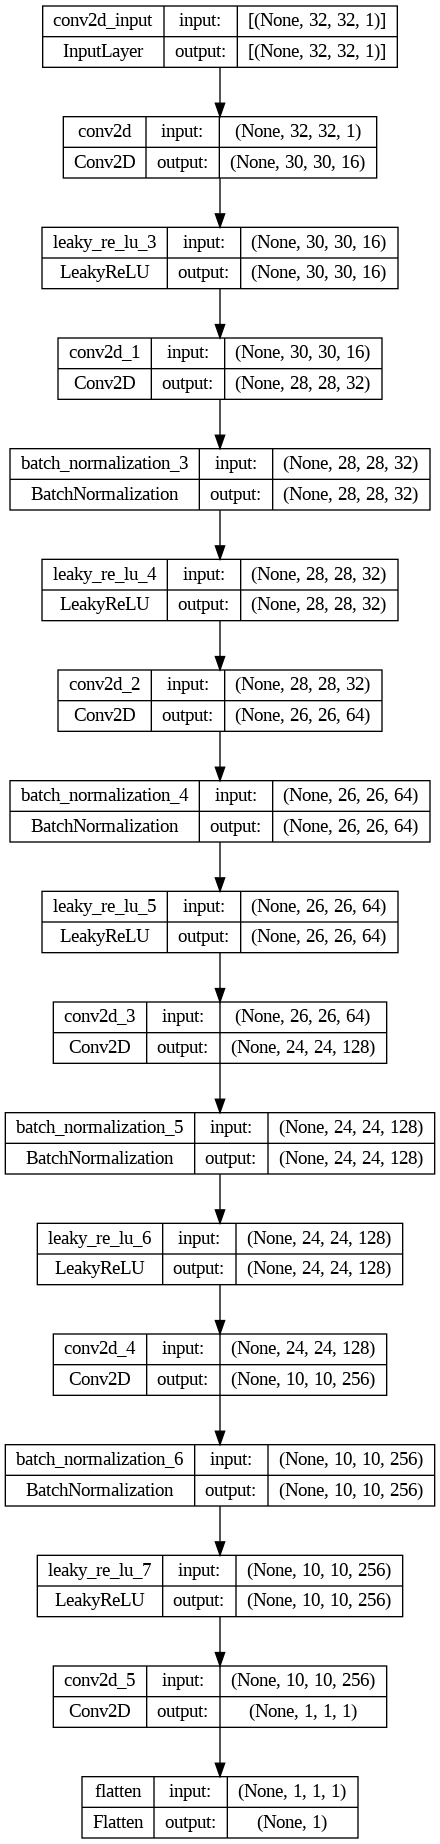

In [ ]:
Discriminator= discriminator_model()
plot_model(Discriminator, show_shapes= True, show_layer_names= True)

In [ ]:
discriminator_classification= Discriminator(Generated_img)
print(discriminator_classification)

tf.Tensor([[0.00039528]], shape=(1, 1), dtype=float32)


## **Generator and Discriminator Loss**

In [ ]:
# Binary cross entropy loss
cross_entropy_loss= tf.keras.losses.BinaryCrossentropy(from_logits= True)

In [ ]:
# Discriminator loss
def discriminator_loss(real_output, fake_output):
  real_loss= cross_entropy_loss(tf.ones_like(real_output), real_output)
  fake_loss= cross_entropy_loss(tf.zeros_like(fake_output), fake_output)
  total_loss= real_loss + fake_loss
  return total_loss

In [ ]:
# Genrator loss
def generator_loss(fake_output):
  return cross_entropy_loss(tf.ones_like(fake_output),fake_output)

In [ ]:
# Using Adam optimiser
generator_optimizer= tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer= tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Epochs to train the model
epochs= 250

### Checkpoints to save the model

In [ ]:
# creating a directory to store generated images in every epoch
if not os.path.isdir('generated_imgs'):
  os.mkdir('generated_imgs')

checkpoint_dir= './training_checkpoints'
ckpt= tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer= discriminator_optimizer,
                          generator= Generator, discriminator= Discriminator)

ckpt_manager= tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=3)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest Checkpont Restored!!!')

## **Training DCGAN for several epochs**
- define and loop the training function.

In [ ]:
# function for one flow of batch training
@tf.function

def train_step(imgs):
  #noise
  noise=tf.random.normal([batch_size, noise_dim])

  # Gradients calculation seperately for generator and discriminator
  with tf.GradientTape() as gen_tape, tf. GradientTape() as dis_tape:

    #Generating images from noise
    generated_images=Generator(noise, training=True)

    # outputs of discriminator
    real_output=Discriminator(imgs,training= True)
    fake_output= Discriminator(generated_images,training=True )

    #loss calculation
    gen_loss= generator_loss(fake_output)
    dis_loss= discriminator_loss(real_output, fake_output)

  # Calculating the gradients
  gradients_of_gen= gen_tape.gradient(gen_loss, Generator.trainable_variables)
  gradients_of_disc= dis_tape.gradient(dis_loss, Discriminator.trainable_variables)

  # Apply gradients to optimizer
  generator_optimizer.apply_gradients(zip(gradients_of_gen, Generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_disc, Discriminator.trainable_variables))

In [ ]:
no_examples_to_generate= 16

seed= tf.random.normal([no_examples_to_generate, noise_dim])

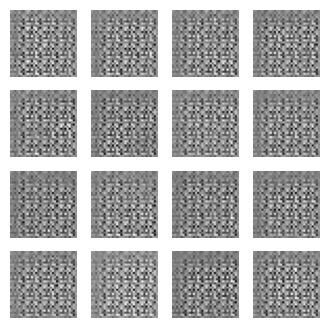

saving_the_checkpoint_for_epoch 4 at ./training_checkpoints/ckpt-109


In [ ]:
for epoch in range (1, epochs+1):
  for image_batch in train_data:
    train_step(image_batch)

    display.clear_output(wait=True)

    predictions= Generator(seed, training=False)

    fig= plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
      plt.axis('off')

    plt.savefig('image_at_the_epoch_{:04d}.png'.format(epoch))
    plt.show()

    ckpt_save_path= ckpt_manager.save()
    print('saving_the_checkpoint_for_epoch',epoch,'at',ckpt_save_path)

## Generating gif of genrated images

In [ ]:
anime_file= 'dcgan_gif_img'

with imageio.writer(anime_file, mode= 'I') as writer:
  filenames=glob.glob('image*.png')
  filenames= soorted(filenames)
  for filename in filenames:
   image= imageio.imread(filenames)
   writer.append_data(image)
  image=imageio.imread(filenames)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anime_file)